## Settings

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to the dataset
train_path = './assets/train/'
test_path = './assets/test/'

# Feature extractor (SIFT)
sift = cv2.SIFT_create(contrastThreshold=0.01)

### Create Descriptors

In [3]:
def extract_descriptors_from_image(image_path):
    """
    Extract exactly a specified number of descriptors from an image using SIFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid: {image_path}")
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found in image: {image_path}")

    return descriptors

In [4]:
def collect_descriptors_all(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        num_des_class = 0
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    
                    # Append descriptors and corresponding labels
                    all_descriptors += descriptors.tolist()
                    all_labels += [i]*len(descriptors)
                    num_des_class += len(descriptors)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
        num_des_tot += num_des_class
        num_des_class_dist.append(num_des_class)
    print(f'total number of descriptors: {num_des_tot}')
    print(f'number of descriptors per class: {num_des_class_dist}')
    
    # Convert to NumPy arrays
    all_descriptors = np.array(all_descriptors)
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels, num_des_class_dist

In [5]:
def collect_descriptors_with_labels(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    all_descriptors.append(descriptors.tolist())
                    all_labels.append(i)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
    
    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [6]:
# Extract descriptors and labels
descriptors_pool, labels_pool, num_des_class_dist = collect_descriptors_all(train_path)

if len(descriptors_pool) > 100000:
    descriptors_pool = descriptors_pool[np.random.choice(descriptors_pool.shape[0], 100000, replace=False)]

print(f'number of remained descriptors: {len(descriptors_pool)}')
print("Descriptor extraction completed.")

cls_name = ['tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']

total number of descriptors: 107604
number of descriptors per class: [16979, 12121, 6756, 9669, 12299, 15063, 16334, 6954, 3223, 8206]
number of remained descriptors: 100000
Descriptor extraction completed.


# Q1. K-means codebook

### Construct K-Means codebook

In [7]:
# Number of clusters (k)
def Kmeans_const_times(k_list, num_iter):
    const_time = []
    avg_time = 0
    codebooks = []

    for k in k_list:
        n_codebooks = []
        for i in range(num_iter):
            start_time = time.perf_counter()
            # Initialize and fit KMeans
            kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
            kmeans.fit(descriptors_pool)
            
            codebook_cons_time = time.perf_counter() - start_time
            avg_time += codebook_cons_time

            n_codebooks.append(kmeans)

        const_time.append(avg_time/num_iter)
        codebooks.append(n_codebooks)
    
    return const_time, codebooks

In [ ]:
k_list = [i*30 for i in range(1,6)]
num_iter = 3

const_time, codebooks = Kmeans_const_times(k_list, num_iter)

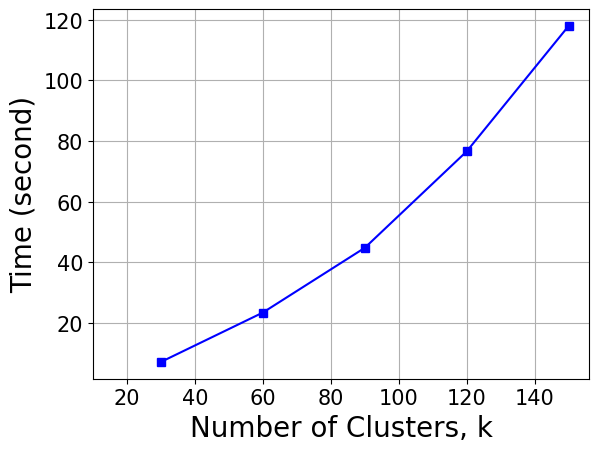

In [168]:
# Plot codebook construction time
plt.plot(k_list, const_time, marker='s', linestyle='-', color='b')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Time (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
plt.grid(True)

In [ ]:
def create_bow_histogram(img_descriptors, kmeans):
    # Predict the closest cluster for each descriptor
    labels = kmeans.predict(img_descriptors)  # This gives the cluster index for each descriptor
    
    k = kmeans.n_clusters
    img_bow = np.zeros(k)

    for label in labels:
        img_bow[label] += 1
        
    img_bow = img_bow / np.sum(img_bow)

    return img_bow

### VQ Time

In [61]:
# Extract train descriptors and labels
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
print("Descriptor extraction completed.")

Descriptor extraction completed.


In [62]:
# Data preparation
train_descriptors_list = []
for i in range(len(train_descriptors)):
    for j in range(len(train_descriptors[i])):
        train_descriptors_list.append(train_descriptors[i][j])

train_descriptors_list = np.array(train_descriptors_list)

In [ ]:
# codebook construction time
k_list = [i*32 for i in range(1,10)]
n_iter = 10
avg_vq_time_list = []
kmeans_list = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
    kmeans.fit(descriptors_pool)
    kmeans_list.append(kmeans)

In [ ]:
# vector quantization time
n_iter = len(train_descriptors)
avg_vq_time_list = []
for k_means in kmeans_list:
    avg_vq_time = 0
    for i in range(n_iter):
        start_time = time.perf_counter()
        kmeans.predict(train_descriptors[i])
        avg_vq_time += time.perf_counter() - start_time
    # avg_vq_time_list.append(avg_vq_time/n_iter)

for k_means in kmeans_list:
    avg_vq_time = 0
    for i in range(n_iter):
        start_time = time.perf_counter()
        kmeans.predict(train_descriptors[i])
        avg_vq_time += time.perf_counter() - start_time
    avg_vq_time_list.append(avg_vq_time/n_iter)

### Apply K-means codebook for train/test data

In [9]:
# Number of clusters (k)
k = 30

start_time = time.perf_counter()

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, verbose=0, n_init=10)
kmeans.fit(descriptors_pool)

codebook_cons_time = time.perf_counter() - start_time

print(f'time for codebook construction time: {codebook_cons_time}')

# Access cluster centers and labels
k_means_codebook = kmeans.cluster_centers_  # Shape: (k, 128)
labels = kmeans.labels_  # Shape: (104008,)

time for codebook construction time: 7.068034199997783


In [209]:
# Extract train descriptors and labels
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

train_bow = []
for descriptors in train_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    train_bow.append(image_bow)

train_bow = np.array(train_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

Descriptor extraction completed.
vector quantization time for train data: 0.556679500034079


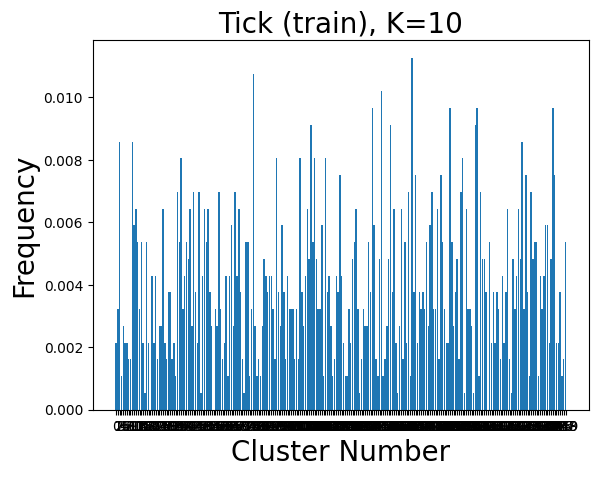

In [210]:
# Plot the histogram
x_axis = np.arange(k)
# trilobite_train = x_train[15:30].mean(axis=0)
plt.bar(x_axis, x_train[3])
plt.title('Tick (train), K=10', fontsize=20)
plt.xlabel('Cluster Number', fontsize=20)
plt.xticks(x_axis)
plt.ylabel('Frequency', fontsize=20)
plt.show()

In [225]:
# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()

test_bow = []
for descriptors in test_descriptors:
    image_bow = create_bow_histogram(descriptors, kmeans)
    test_bow.append(image_bow)

test_bow = np.array(test_bow)

vq_time = time.perf_counter() - start_time
print(f'vector quantization time for test data: {vq_time}')

x_test = test_bow
y_test = test_labels

Descriptor extraction completed.
vector quantization time for test data: 0.30466669995803386


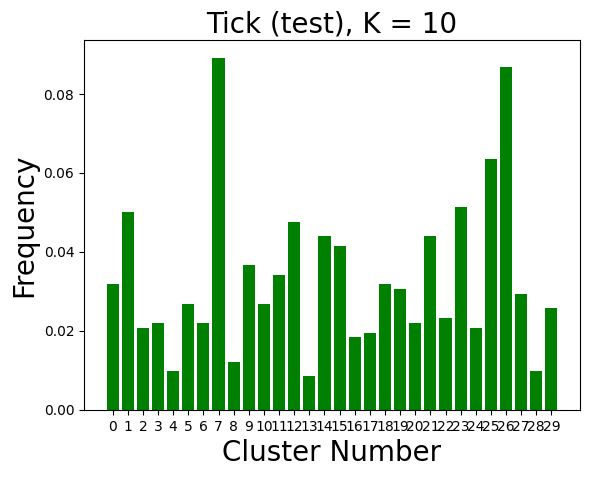

In [226]:
# Plot the histogram
x_axis = np.arange(k)
# trilobite_test = x_test[15:30].mean(axis=0)

plt.bar(x_axis, x_test[3], color='g')
plt.title('Tick (test), K = 10', fontsize=20)
plt.xlabel('Cluster Number', fontsize=20)
plt.xticks(x_axis)
plt.ylabel('Frequency', fontsize=20)
plt.show()

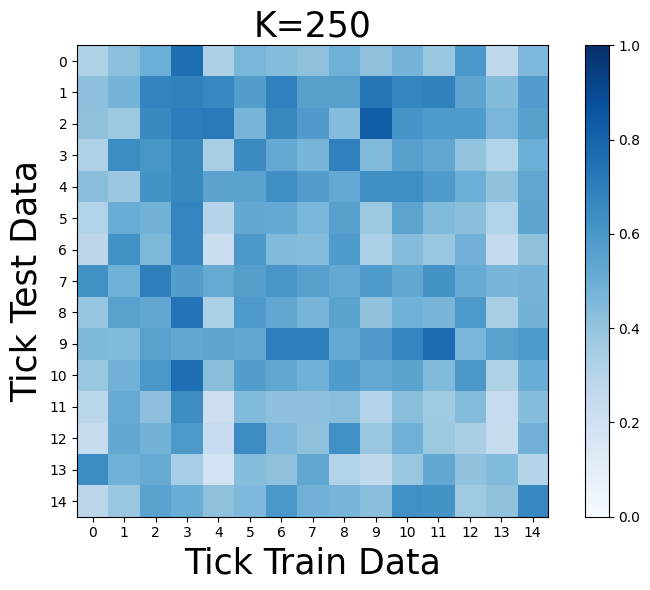

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 15x15 matrix
cls_1 = x_train[0:15] / np.linalg.norm(x_train[0:15], axis=1).reshape(15,-1)
cls_2 = x_test[0:15] / np.linalg.norm(x_test[0:15] , axis=1).reshape(15,-1)

matrix = cls_1 @ cls_2.T

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Blues', vmin=0, vmax=1)

# Add colorbar
plt.colorbar()

# Customize axes (optional)
plt.title('K=250', fontsize=25)
plt.xlabel('Tick Train Data', fontsize=25)
plt.ylabel('Tick Test Data', fontsize=25)

# Optionally, set ticks and labels
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))

# Display the matrix
plt.tight_layout()
plt.show()


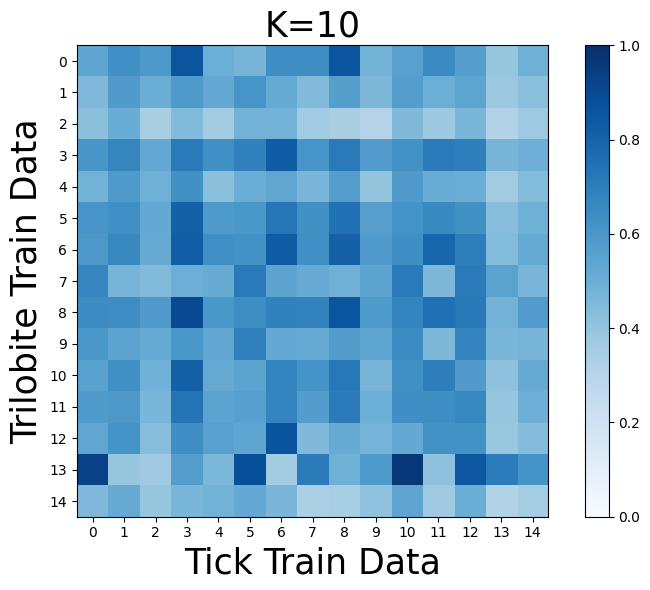

In [220]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 15x15 matrix
cls_1 = x_train[0:15] / np.linalg.norm(x_train[0:15], axis=1).reshape(15,-1)
cls_2 = x_train[15:30] / np.linalg.norm(x_train[0:15] , axis=1).reshape(15,-1)

matrix = cls_1 @ cls_2.T

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Blues', vmin=0, vmax=1)

# Add colorbar
plt.colorbar()

# Customize axes (optional)
plt.title('K=10', fontsize=25)
plt.xlabel('Tick Train Data', fontsize=25)
plt.ylabel('Trilobite Train Data', fontsize=25)

# Optionally, set ticks and labels
plt.xticks(np.arange(15))
plt.yticks(np.arange(15))

# Display the matrix
plt.tight_layout()
plt.show()


### Check vector quantization time

In [ ]:
const_time, codebooks = Kmeans_const_times(k_list, num_iter)

In [31]:
def vq_process_time(data_descriptors, kmeans):
    start_time = time.perf_counter()

    data_bow = []
    for descriptors in data_descriptors:
        image_bow = create_bow_histogram(descriptors, kmeans)
        data_bow.append(image_bow)
    data_bow = np.array(data_bow)
    vq_time = time.perf_counter() - start_time

    return vq_time

In [ ]:
n_iter = 30
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)

avg_vq_time_list = []

for codebook in codebooks:
    codebook = codebook[0]
    avg_vq_time = 0
    for i in range(n_iter):
        vq_time = vq_process_time(test_descriptors, codebook)
        avg_vq_time += vq_time
    avg_vq_time_list.append(avg_vq_time/n_iter)

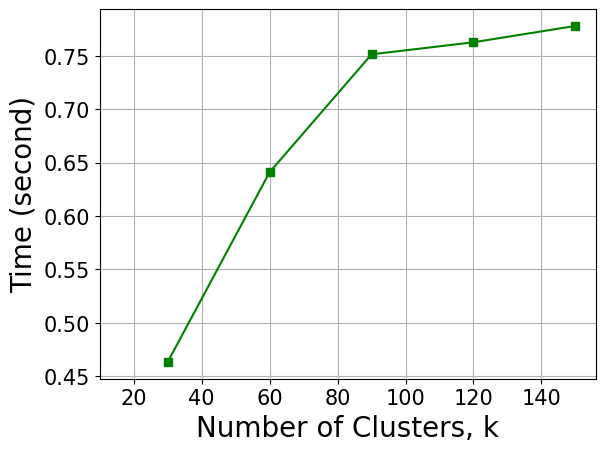

In [166]:
# Plot accuracy on the first subplot
plt.plot(k_list, avg_vq_time_list, label='vector quantization time', marker='s', linestyle='-', color='g')
plt.xlim(left=10)
plt.xlabel('Number of Clusters, k', fontsize=20)
plt.ylabel('Time (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Accuracy over number of estimators')
# plt.legend(fontsize=15)
plt.grid(True)